# Figures: RS applications and ML tasks

This notebook generates Fig.1 of the manuscript, as well as other visualizations of RS applications and ML tasks.

After a few exploration using classic figure type, I ended up using a circular patch grouping/representation.
The computations for the circles sizes and positions is made with `circlify`, see their [GitHub](https://github.com/elmotec/circlify/tree/main) for examples.
The plotting is based on `circlify.bubbles` function (using `matplotlib`), but I had to overwrite it to fit my needs.

Use the circles' colors to indicate **Tasks** and hatching patterns for **Modalities**.


In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import circlify as circ
# import seaborn as sns

from utils.utils import print_pretty_df, wrap_label, support_labels, r, y, g, b, e
from utils.metadata import plot_colors, general_task_colors, rename_application


pickleName = "all_datapoints.pkl"
datapointsDfPath = Path("..") / "data" / "Dataframes" / pickleName
original_df = pd.read_pickle(datapointsDfPath)

versionTag = "_v5"
figureName = "Applications_tasks_bubbles" + versionTag
saveFormat = "pdf"
transparency = 0.6
saveFigurePath = Path("..") / "data" / "Figures" / "RQ_figures" / f"{figureName}.{saveFormat}"

In [2]:
print_pretty_df(original_df[["BBT Citation Key", "Task", "Dataset", "Application"]].sort_values(by="Application"))
print(original_df["Application"].unique())

+----+-------------------------------------------------------+----------------------+---------------------------------------------------+-----------------------------------------+
|    |                   BBT Citation Key                    |         Task         |                      Dataset                      |               Application               |
+----+-------------------------------------------------------+----------------------+---------------------------------------------------+-----------------------------------------+
| 9  |              huangEdgeTrustworthyAI2024               |    Classification    |         UAV RGB (cust.) {Classification}          |       Air quality classification        |
| 39 |           wuDesignImplementationRemote2021            |   Object detection   | Google Earth Studio RGB (sim.) {Object Detection} |           Aircraft detection            |
| 56 |          gargAircraftDetectionSatellite2024           |   Object detection   |             Ai

## Helper functions


In [3]:
def get_task_for_application(app, df):
    """
    Retrieves the ML task for a given application name from the provided DataFrame.
    If multiple tasks exist, pick the most frequent one.
    """
    tasks = df[df['Application'] == app]['Task']
    if len(tasks) == 0:
        return None
    return tasks.value_counts().idxmax()

def get_task_color(app, df, task_colors):
    """
    Returns a color corresponding to the task of the given application.
    If no matching task is found, defaults to white.
    """
    task = get_task_for_application(app, df)
    return task_colors.get(task, 'white')

def get_modality_hatch_pattern(df, app, hatch_patterns):
    """
    Returns a hatch pattern based on the application modality.
    If multiple modalities exist, pick the most frequent one (or combine if needed).
    """
    # Example approach: you might have another function or DataFrame to look up the modalities
    # For now, assume the user has a function called get_modality_hatch_pattern(...) or similar
    return determine_hatch_pattern(df, app, hatch_patterns, 'Modality')  # reusing existing approach

def determine_hatch_pattern(df, app, patterns, column='Modality'):
    """
    Returns a hatch pattern based on a Dataframe column.
      1. If a single instance (of the column) is found in >= 70% of the rows, return its pattern.
      2. Otherwise, if at least two modalities are present:
         If the top two instances occur with roughly close frequency, combine their patterns.
         Otherwise, return only the top instance's pattern.
      3. If no matches or empty, return an empty pattern.

    'patterns' is a dict like (for modalities):
        {
         'RGB': '//',
         'HSI': '||',
         'SAR': '++',
         '1D': '*',
        }
    """
    applications = df[df['Application'] == app][column]
    if column == 'Modality':
        applications = applications.replace({'RGB + infrared': 'RGB', 'RGB + MMW': 'RGB'})

    if len(applications) == 0:
        return ""

    # Get frequencies of each instance
    counts = applications.value_counts()
    total = counts.sum()
    if len(counts) == 1:
        return patterns.get(counts.index[0], "")

    # Sort by frequency (already sorted from value_counts by default), check if top instance >= 70%
    topInstance = counts.index[0]
    topCount = counts.iloc[0]
    if topCount / total >= 0.7:
        return patterns.get(topInstance, "")

    # Otherwise, check if second-most frequent is "roughly" close
    if len(counts) >= 2:
        secondInstance = counts.index[1]
        secondCount = counts.iloc[1]

        # Let's say "roughly close" means the ratio of secondCount to topCount is at least 0.7
        if secondCount / topCount >= 0.7:
            patternA = patterns.get(topInstance, "")
            patternB = patterns.get(secondInstance, "")
            return patternA + patternB
        else:
            return patterns.get(topInstance, "")

## The plotting function

Warning: this is not the most straightforward way. Indeed, Matplotlit has an famous bug that makes hatching patterns transparent when exporting the figure in vector formats (`.svg` or `.pdf`), see below for a minimum working example. In case you want to reproduce the figure but are not interested by hatching check the commit history.


In [13]:
def plot_bubbles_custom_tasks_color(
    circles,
    labels,
    df_for_tasks,
    task_colors,
    hatch_patterns=None,
    fontsize=8,
    lim=None,
    withBase=True,
    title="",
):
    """
    Variation of plot_bubbles_custom that:
      - Leaves group-level circles white (with borders).
      - Child-level circles are colored by ML Task (from df_for_tasks).
      - Maintains the hatch pattern for modalities if not 'None'.
      - Adds legends for tasks (color) and modalities (hatch).
    """
    withHatch = False if hatch_patterns is None else True
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')
    # plt.rcParams['hatch.linewidth'] = 1.5

    # Identify circles
    base_circle = circles[0]
    base_label = labels[0]
    group_circles = []
    child_circles = []
    for c_obj, lbl in zip(circles[1:], labels[1:]):
        if c_obj.level == 1:
            group_circles.append((c_obj, lbl))
        elif c_obj.level == 2:
            child_circles.append((c_obj, lbl))
        else:
            raise ValueError(f"Circles with Levels higher than 2 not supported: {c_obj}, level {c_obj.level}")

    # Draw the base circle (enclosure)
    if withBase:
        ax.add_patch(
            plt.Circle(
                (base_circle.x, base_circle.y),
                base_circle.r,
                fill=False,
                linewidth=1
            )
        )
        ax.text(
            base_circle.x,
            base_circle.y - base_circle.r + 0.2,
            "Addressed RS Applications",
            ha='center',
            va='center',
            fontsize=fontsize + 5
        )

    # Draw group-level circles: no fill, just a border, bigger label at bottom
    for c_obj, lbl in group_circles:
        x, y, r = c_obj.x, c_obj.y, c_obj.r
        ax.add_patch(
            plt.Circle(
                (x, y),
                r,
                fill=False,
                linewidth=1,
                edgecolor='black'
            )
        )
        ax.text(
            x,
            y - r + 0.04 if lbl.startswith("Weather") else y - r + 0.02,
            lbl if lbl.startswith("UAV") else wrap_label(lbl, 10),
            ha='center',
            va='bottom',
            fontsize=fontsize + 3,
            fontweight='bold'
        )

    # Draw child-level circles: color by task, hatch by modality
    for c_obj, lbl in child_circles:
        x, y, r = c_obj.x, c_obj.y, c_obj.r
        circle_color = get_task_color(lbl, df_for_tasks, task_colors)
        circle_hatch = determine_hatch_pattern(df_for_tasks, lbl, hatch_patterns, 'Modality') if withHatch else None

        # Generate circular coordinates
        angles = np.linspace(0, 2*np.pi, 120)
        xvals = x + r * np.cos(angles)
        yvals = y + r * np.sin(angles)

        # choose hatch linewidth per-circle (1 for 'o', otherwise 1.5)
        hatch_lw = 1.0 if circle_hatch == 'o' else 1.5

        # First fill: face color (semi-transparent) + hatch
        ax.fill(
            xvals,
            yvals,
            color=circle_color,
            alpha=transparency,
            hatch=circle_hatch,
            linewidth=hatch_lw
        )
        # Second fill: no face color, but the same hatch color as edge
        ax.fill(
            xvals,
            yvals,
            color='None',
            edgecolor=circle_color,
            alpha=transparency,
            hatch=circle_hatch,
            linewidth=hatch_lw
        )

        # Custom behavior for child circles of Navigation (too long labels)
        if lbl.startswith("Safe UAV"):
            support_labels(ax, [-0.68, -0.19], [-0.1, -0.19], [-0.05, -0.05], lbl, [x, y], color='black', linewidth=1, fontsize=fontsize+1)
        elif lbl.startswith("UAV obstacles"):
            support_labels(ax, [0.5, -0.2], [0.1, -0.2], [0.05, -0.05], lbl, [x, y], color='black', linewidth=1, fontsize=fontsize+1)
        else:
            ax.text(
                x,
                y,
                wrap_label(lbl, 12),
                ha='center',
                va='center',
                fontsize=fontsize + 1
            )

    # Auto-limit the axes if lim is not provided
    if lim is None:
        lim = max(
            max(abs(c_obj.x) + c_obj.r, abs(c_obj.y) + c_obj.r)
            for c_obj in circles
        )
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

    # Build legend for tasks (colors) - now in top right corner with title
    TaskOrder = ['Classification', 'Segmentation - Pixel', 'Segmentation - Tile', 'Object detection', 'Regression']
    task_handles = [mpatches.Patch(facecolor=task_colors[task], edgecolor='black', alpha=transparency, label=task) for task in TaskOrder]
    task_legend = ax.legend(handles=task_handles, fontsize=8, loc="upper left", bbox_to_anchor=(-0.001, 0.99), title="ML Tasks", title_fontsize=fontsize + 3)
    ax.add_artist(task_legend)

    # Build legend for modalities (hatches) - now in top left corner with title
    if withHatch:
        modality_patches = []
        for modality, pat in hatch_patterns.items():
            patch = mpatches.Patch(
                    facecolor='white',
                    edgecolor='black',
                    hatch=pat*4 if (pat == '/') else pat*3,
                    label=modality,
                    linewidth=0.5
                )
            modality_patches.append(patch)
        modality_legend = ax.legend(handles=modality_patches, fontsize=8, loc="upper right", bbox_to_anchor=(1.001, 0.99), title="Data Modality", title_fontsize=fontsize + 3)
        ax.add_artist(modality_legend)

    plt.title(title)
    
    # plt.tight_layout()
    fig.savefig(saveFigurePath, format=saveFormat, bbox_inches="tight")
    plt.show()

## Grouping by old thematic


UAV obstacles detection: color=#A71313, hatch='|', hatch_lw=1.5
Safe UAV landing site identification: color=#54a1a1, hatch='|', hatch_lw=1.5
Anomaly detection: color=#54a1a1, hatch='/', hatch_lw=1.5
Railway defects detection: color=#A71313, hatch='|', hatch_lw=1.5
Deforestation detection: color=#54a1a1, hatch='|', hatch_lw=1.5
Air quality classification: color=#2066a8, hatch='/', hatch_lw=1.5
Aircraft detection: color=#A71313, hatch='|', hatch_lw=1.5
Cloud extraction: color=#389339, hatch='|', hatch_lw=1.5
Oil spills feature extraction: color=#aaaaaa, hatch='o', hatch_lw=1.0
Ship detection: color=#A71313, hatch='o', hatch_lw=1.0
Urban areas: color=#389339, hatch='|', hatch_lw=1.5
Ship identification: color=#2066a8, hatch='|', hatch_lw=1.5
Flying-object detection: color=#A71313, hatch='|', hatch_lw=1.5
Military targets identification: color=#2066a8, hatch='o', hatch_lw=1.0
Cloud coverage classification: color=#2066a8, hatch='|', hatch_lw=1.5
Miscellaneous targets: color=#A71313, hatch='

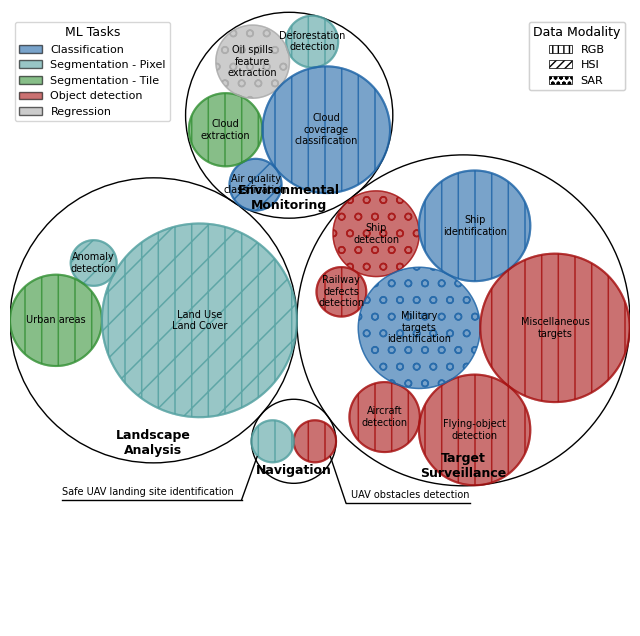

In [5]:
# -------------------------- Grouping & renaming --------------------------
datapointsDf = original_df.copy()
datapointsDf.replace({
    # 'Redshift estimation [regression]': 'Redshift estimation',
    'Railway track fastener defect detection': 'Railway defects detection',
    'Diverse detection': 'Miscellaneous targets',
    'General': 'Unsupervised'
}, inplace=True)

application_to_group = {
    #  --- Environmental Monitoring --- 
    "Cloud coverage classification": "Environmental Monitoring",
    "Cloud extraction": "Environmental Monitoring",
    "Air quality classification": "Environmental Monitoring",
    "Deforestation detection": "Environmental Monitoring",
    "Oil spills feature extraction": "Environmental Monitoring",
    #  --- Landscape Analysis --- 
    "Land Use Land Cover": "Landscape Analysis",
    "Anomaly detection": "Landscape Analysis",
    "Urban areas": "Landscape Analysis",
    "Unsupervised": "Landscape Analysis",

    #  --- Target Surveillance --- 
    "Ship detection": "Target Surveillance",
    "Ship identification": "Target Surveillance",
    "Aircraft detection": "Target Surveillance",
    "Flying-object detection": "Target Surveillance",
    "Military targets identification": "Target Surveillance",
    "Miscellaneous targets": "Target Surveillance",
    "Railway defects detection": "Target Surveillance", # Diverse?
    #  --- Miscellaneous (Diverse) --- 
    # "Redshift estimation": "Diverse",
    
    #  --- Navigation --- 
    "UAV obstacles detection": "Navigation",
    "Safe UAV landing site identification": "Navigation",
}

for app in datapointsDf["Application"].unique():
    if app not in application_to_group:
        print(f"Application '{r}{app}{e}' not in application_to_group")

datapointsDf['Group'] = datapointsDf['Application'].map(application_to_group)

# -------------------------- Build a DataFrame of counts grouped by (Group, Application) --------------------------
# datapointsDf["Application"] = datapointsDf["Application"].apply(rename_application)
df_counts = datapointsDf[['Group', 'Application']].value_counts().reset_index(name='Count')
df_counts.columns = ['Group', 'Application', 'Count']
df_counts.sort_values(by=['Group'], inplace=True)

# Build hierarchical data for circlify
data = []
for group_val, group_subset in df_counts.groupby('Group'):
    total_count = group_subset['Count'].sum()
    children = []
    for _, row in group_subset.iterrows():
        children.append({'id': row['Application'], 'datum': row['Count']})
    data.append({
        'id': group_val,
        'datum': total_count,
        'children': children
    })
circles = circ.circlify(data, show_enclosure=True)
labels = [c.ex.get("id", "") if c.ex else "" for c in circles]

# Prepare color dictionary for tasks
task_colors = general_task_colors

# Prepare hatch patterns for modalities
modality_patterns = {
    'RGB': '|',
    'HSI': '/',
    'SAR': 'o',
    # '1D': '*',
}

# # ----- Plot v1: Tasks only -----
# plot_bubbles_custom_tasks_color(
#     circles=circles,
#     labels=labels,
#     df_for_tasks=datapointsDf,  # the complete DF to query tasks
#     task_colors=task_colors,
#     hatch_patterns=None,
#     fontsize=6,
#     withBase=False,
#     title="V1: Hierarchical Circle Packing with Tasks"
# )

# ----- Plot v2: Tasks and Modalities -----
plot_bubbles_custom_tasks_color(
    circles=circles,
    labels=labels,
    df_for_tasks=datapointsDf,  # the complete DF to query tasks
    task_colors=task_colors,
    hatch_patterns=modality_patterns,
    fontsize=6,
    withBase=False,
    title="", #"V2: Hierarchical Circle Packing with Tasks and Modalities"
)

## New Thematic Grouping


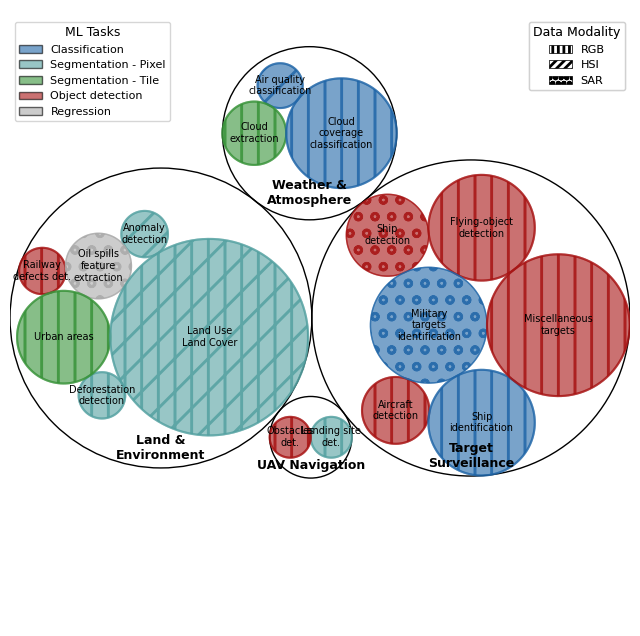

In [14]:
NewDatapointsDf = original_df.copy()

application_to_group = {
    #  --- Target Surveillance --- 
    "Ship detection": "Target Surveillance",
    "Ship identification": "Target Surveillance",
    "Aircraft detection": "Target Surveillance",
    "Flying-object detection": "Target Surveillance",
    "Military targets identification": "Target Surveillance",
    "Diverse detection": "Target Surveillance",

    #  --- Land & Environment --- 
    "Railway track fastener defect detection": "Land & Environment",
    "Land Use Land Cover": "Land & Environment",
    "Anomaly detection": "Land & Environment",
    "Urban areas": "Land & Environment",
    "Deforestation detection": "Land & Environment",
    "Oil spills feature extraction": "Land & Environment",

    #  --- Weather & Atmosphere --- 
    "Cloud coverage classification": "Weather & Atmosphere",
    "Cloud extraction": "Weather & Atmosphere",
    "Air quality classification": "Weather & Atmosphere",
    
    #  --- UAV Navigation --- 
    "UAV obstacles detection": "UAV Navigation",
    "Safe UAV landing site identification": "UAV Navigation",
}

for app in NewDatapointsDf["Application"].unique():
    if app not in application_to_group:
        print(f"Application '{r}{app}{e}' not in application_to_group")

NewDatapointsDf['Group'] = NewDatapointsDf['Application'].map(application_to_group)

NewDatapointsDf.replace({
    # 'Redshift estimation [regression]': 'Redshift estimation',
    'Railway track fastener defect detection': 'Railway defects det.',
    'Diverse detection': 'Miscellaneous targets',
    'UAV obstacles detection': 'Obstacles det.',
    'Safe UAV landing site identification': 'Landing site det.',
}, inplace=True)


# -------------------------- Build a DataFrame of counts grouped by (Group, Application) --------------------------\
df_counts = NewDatapointsDf[['Group', 'Application']].value_counts().reset_index(name='Count')
df_counts.columns = ['Group', 'Application', 'Count']
df_counts.sort_values(by=['Group'], inplace=True)

# Build hierarchical data for circlify
data = []
for group_val, group_subset in df_counts.groupby('Group'):
    total_count = group_subset['Count'].sum()
    children = []
    for _, row in group_subset.iterrows():
        children.append({'id': row['Application'], 'datum': row['Count']})
    data.append({
        'id': group_val,
        'datum': total_count,
        'children': children
    })
circles = circ.circlify(data, show_enclosure=True)
labels = [c.ex.get("id", "") if c.ex else "" for c in circles]

# Prepare color dictionary for tasks
task_colors = general_task_colors

# Prepare hatch patterns for modalities
modality_patterns = {
    'RGB': '|',
    'HSI': '/',
    'SAR': 'o',
}

plot_bubbles_custom_tasks_color(
    circles=circles,
    labels=labels,
    df_for_tasks=NewDatapointsDf,  # the complete DF to query tasks
    task_colors=task_colors,
    hatch_patterns=modality_patterns,
    fontsize=6,
    withBase=False,
    title="", #"V2: Hierarchical Circle Packing with Tasks and Modalities"
)

### Aditionnal statistics


In [7]:
nb_focus_on_target = len(datapointsDf[datapointsDf['Group'] == 'Target Surveillance'])
nb_focus_on_env = len(datapointsDf[datapointsDf['Group'] == 'Environmental Monitoring'])
nb_focus_on_land = len(datapointsDf[datapointsDf['Group'] == 'Landscape Analysis'])
nb_focus_on_nav = len(datapointsDf[datapointsDf['Group'] == 'Navigation'])

nb_defense_app = len(datapointsDf[datapointsDf["Application"].isin(["Ship detection", "Ship identification", "Aircraft detection", "Flying-object detection", "Military targets identification"])])

print(f"{nb_focus_on_target} datapoints in 'Target Surveillance' group or {nb_focus_on_target/len(datapointsDf)*100:.2f}%")
print(f"{nb_defense_app} datapoints in 'Target Surveillance' group related to defense applications or {nb_defense_app/len(datapointsDf)*100:.2f}%")
print(f"{nb_focus_on_env} datapoints in 'Environmental Monitoring' + {nb_focus_on_land} datapoints in 'Landscape Analysis'' groups or {(nb_focus_on_env+nb_focus_on_land)/len(datapointsDf)*100:.2f}%")
print(f"{len(datapointsDf)} datapoints in total")

nb_pure_rgb = len(datapointsDf[datapointsDf['Modality'] == ('RGB')])
nb_rgb = len(datapointsDf[datapointsDf['Modality'].str.contains('RGB')])
print(f"{nb_pure_rgb} datapoints used only RGB data or {nb_rgb/len(datapointsDf)*100:.2f}%")
print(f"OR {nb_rgb} datapoints used RGB data and more, e.g., including RGB + MMW, or {nb_rgb/len(datapointsDf)*100:.2f}%")

31 datapoints in 'Target Surveillance' group or 45.59%
21 datapoints in 'Target Surveillance' group related to defense applications or 30.88%
12 datapoints in 'Environmental Monitoring' + 23 datapoints in 'Landscape Analysis'' groups or 51.47%
68 datapoints in total
41 datapoints used only RGB data or 64.71%
OR 44 datapoints used RGB data and more, e.g., including RGB + MMW, or 64.71%


## Older Figures

### Classic bar plotting


C:\Users\leon_ce\AppData\Local\Temp\ipykernel_37068\2922240380.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bottom_stack[i] + val / 2,


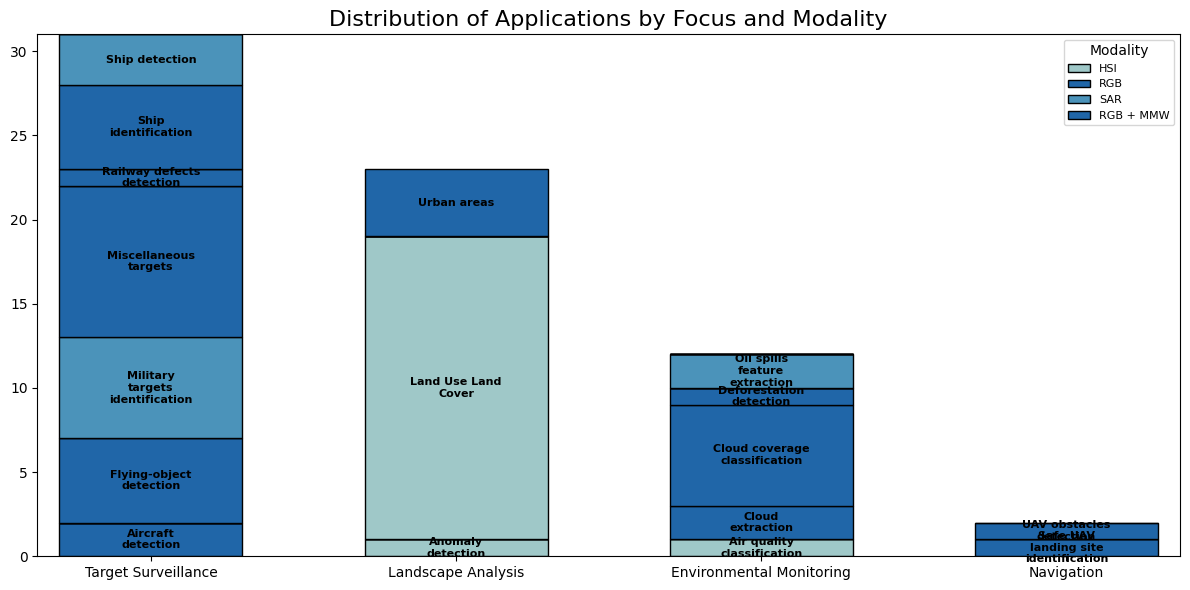

In [8]:
def get_modality_color(modality_str):
    # Custom mapping:
    # - If "RGB" in the string, use blue
    # - "HSI" => purple
    # - "SAR" => gray
    # - "1D" => no fill (white)
    # Default => some fallback color
    if "RGB" in modality_str.upper():
        return "#2066a8"
    elif modality_str.upper() == "HSI":
        return "#9fc8c8"
    elif modality_str.upper() == "SAR":
        return "#4B93BA"
    elif modality_str.upper() == "1D":
        return "none"  # White or transparent
    raise ValueError(f"Unknown modality: {modality_str}")
    # "Classification": "#2066a8",
    # "Pixel classification": "#1f6f6f",
    # "Segmentation": "#9fc8c8",
    # "Object detection": "#af2c2c",
    # "Regression": "#4B93BA",

def plot_stacked_bar_with_modality_colors(data):
    # Prepare DataFrame
    df = data.reset_index(name='Count')
    df['Application Wrapped'] = df['Application'].apply(wrap_label)

    # Pivot with sum to handle duplicates
    pivot_df = df.pivot_table(
        index='Group',
        columns='Application Wrapped',
        values='Count',
        aggfunc='sum',
        fill_value=0
    )

    # Sort tasks by total count descending (biggest on left, smallest on right)
    pivot_df = pivot_df.loc[pivot_df.sum(axis=1).sort_values(ascending=False).index]

    # Keep track of which modalities have been labeled
    already_labeled = set()

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom_stack = np.zeros(len(pivot_df))

    for app in pivot_df.columns:
        # Find a representative row in df for this app (first match)
        sub_df = df.loc[df['Application Wrapped'] == app]
        if not sub_df.empty:
            modality = sub_df.iloc[0]['Modality']
            bar_color = get_modality_color(modality)
        else:
            # Fallback if not found
            modality = "Unknown"
            bar_color = "lightgray"

        # Show each modality in legend only once
        if modality not in already_labeled:
            label_for_legend = modality
            already_labeled.add(modality)
        else:
            label_for_legend = None

        ax.bar(
            pivot_df.index,
            pivot_df[app],
            bottom=bottom_stack,
            label=label_for_legend,
            color=bar_color,
            edgecolor='black',
            width=0.6
        )

        # Add labels to each sub-bar (in black)
        for i, val in enumerate(pivot_df[app]):
            if val > 0:
                ax.text(
                    i,
                    bottom_stack[i] + val / 2,
                    app,
                    ha='center',
                    va='center',
                    fontsize=8,
                    color='black',
                    fontweight='bold'
                )

        bottom_stack += pivot_df[app]

    # Customization
    ax.set_title("Distribution of Applications by Focus and Modality", fontsize=16)
    ax.set_xticks(range(len(pivot_df.index)))
    ax.set_xticklabels(pivot_df.index, rotation=0, fontsize=10)  # No rotation
    ax.legend(title='Modality', loc='upper right', fontsize=8)
    ax.margins(x=0.02)  # Less space behind bars
    plt.tight_layout()
    plt.show()

# Example usage
data = datapointsDf[["Modality", "Application", "Group"]].value_counts()
plot_stacked_bar_with_modality_colors(data)

### Minimal Working Example: `matplotlib` colored hatching invisible in PDF format

See [open mpl issue](https://github.com/matplotlib/matplotlib/issues/12367) or [open mpl issue](https://github.com/matplotlib/matplotlib/issues/16883)


#### This piece of code shows the bug


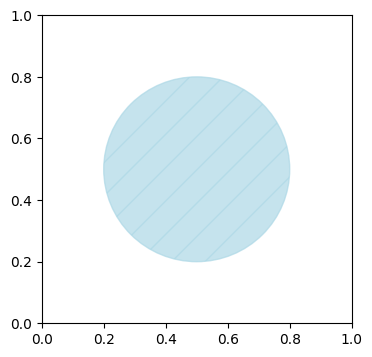

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_hatched_circle():
    fig, ax = plt.subplots(figsize=(4,4))

    ax.add_patch(patches.Circle(
        (0.5, 0.5),
        0.3,
        color='lightblue',      # Use color or facecolor+edgecolor
        alpha=0.7,
        hatch='/',              # Any pattern: '/', '|', 'x', 'o', etc.
        # edgecolor='lightblue',
    ))
    # plt.savefig("hatched_circle.png", dpi=300)
    # plt.savefig("hatched_circle.pdf", dpi=300)
    plt.show()

if __name__ == "__main__":
    draw_hatched_circle()

#### This is a work around, credits to [@dcodrut](https://github.com/dcodrut)


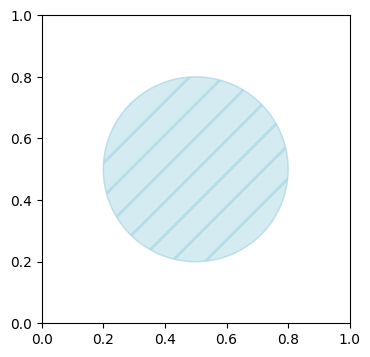

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_hatched_circle():
    fig, ax = plt.subplots(figsize=(4,4))
    # Optional: tweak hatch linewidth globally
    plt.rcParams["hatch.linewidth"] = 2.0

    # Create a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    x = 0.5 + 0.3 * np.cos(theta)
    y = 0.5 + 0.3 * np.sin(theta)

    # Use plt.fill to create a hatched circle
    ax.fill(x, y, color='lightblue', alpha=0.5, hatch='/')
    ax.fill(x, y, color='None', edgecolor='lightblue', alpha=0.5, hatch='/')

    # Keep aspect ratio and view area
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Save to PNG and PDF
    # plt.savefig("hatched_circle.png", dpi=300)
    # plt.savefig("hatched_circle.pdf", dpi=300)
    plt.show()

if __name__ == "__main__":
    draw_hatched_circle()